# Implement K2 algorithm

In [1]:
library("bnstruct")
library("dplyr")
library("bnlearn")

Warning message:
"package 'bnstruct' was built under R version 3.6.3"
Loading required package: bitops

Loading required package: igraph

Warning message:
"package 'igraph' was built under R version 3.6.3"

Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union


Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:igraph':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'bnlearn' was built under R version 3.6.3"

Attaching package: 'bnlearn'


The following objects are masked from 'package:bnstruct':

    impute, read.bif, read.dsc, read.net, shd, write.dsc


The following objects are masked from

In [2]:
# Alpha i j k with fixed i, j
alpha <- function(data, k, parents, phi, pi, vi){

    if (is.null(pi) == FALSE){
            return (length(which(data == vi[k] & apply(parents, 1, function(x)
                identical(as.numeric(x), phi)))))
        }
    else {return (length(which(data == vi[k])))}
}

In [3]:
f <- function(i, pi, data, l){
    #f <- 1 # Output
    if (l==TRUE) {f <- 0}
    else {f <- 1 }
    uniq <- lapply(data[pi], unique)
    Phi <- expand.grid(uniq)                          # List of possible
                                                      # instantiations of 
                                                      # the parents
    Vi <- as.numeric(unlist(unique(data[i]))) # List of possible value for x_i
    r <- length(Vi)
    q <- nrow(Phi)
    x_i <- data[[i]] # x_i in the dataset
    x_parents <- data[pi] # x_parents in the dataset
    
    if(q==0){q<-1} # When there are no parents
    
    for (j in 1:q){
        Phi_j <- as.numeric(Phi[j, ]) # Fix a combination of instantiations
                                          # for the parents
        prod_2 <- 1
        Nij <- 0
        k <- seq(1:r)

        # List of alpha value for all values of k
        a <- sapply(k, alpha, data = x_i, parents = x_parents, 
                            phi = Phi_j, pi = pi, vi = Vi)
        if (l == FALSE){
            Nij <- sum(a)
            prod_2 <- prod(factorial(a))
            f <- f * factorial(r-1) / factorial(Nij + r - 1) * prod_2
            }
        
        else{
            if (any(a==0)) {a[a==0] <- 0.01}  
            Nij <- sum(a)
            prod2 <- sum(a * log(a) - a)
            f <- f + ((r-1) * log(r-1) - (r-1)) - ((Nij + r - 1)
                    * log(Nij + r - 1) - (Nij + r - 1)) + prod2
            }
        }
    return(f)
}

In [4]:
K2 <- function(n, u, order, D, l = FALSE){
    
    D <- D[order] # Order database respect to order nodes
    
    for (i in 1:n){
    pi <- NULL # Set of parents
    P_old <- f(i, pi, D, l)
    PROCEED <- TRUE

    while( PROCEED == TRUE && length(pi) < u ){
        Pred <- order[1 : i - 1]   # Precedent nodes
        nodes <- setdiff(Pred, pi) # Difference between actual parents and
                                   # previous nodes
        P_max <- NULL # List of P for different z

        # Find the z that maximizes P(i, pi)
        if (length(nodes) !=0){
        for (j in 1:(length(nodes))){
                z <- nodes[j] 
                pi_new <- c(pi, z)
                P_max <- c(P_max, f(i, pi_new, D, l))
            }
        }

        # For the first iteraction
        else {
            P_max <- c(P_max, f(i, pi, D, l))
            }

        z <- nodes[which.max(P_max)] # z that maximizes P(i, pi)
        pi_new <- c(pi,z)  
        P_new <- max(P_max)

        if (P_new > P_old){
            P_old <- P_new
            pi <- c(pi,z)
        }

        else{PROCEED <- FALSE}
        }
    cat ("Node: ", order[i], " Parents: ", pi, "\n");
    }
}

* Dataset taken from: "*Illustration of the K2 Algorithm for learning Bayes Net Structures*" 

In [5]:
x1 <- c(1, 1, 0, 1, 0, 0, 1, 0, 1, 0)
x2 <- c(0, 1, 0, 1, 0, 1, 1, 0, 1, 0)
x3 <- c(0, 1, 1, 1, 0, 1, 1, 0, 1, 0)

D <- data.frame(x1, x2, x3)

n <- ncol(D) # Number of nodes
u <- 2 # Upper limit to the number of parents
order <- names(D) # Order of nodes


In [6]:
start.time <- Sys.time()
K2(n, u, order, D, l=FALSE) 
end.time <- Sys.time()
cat("K2 algorithm without log:",end.time - start.time,"sec \n")
cat("\n")
start.time <- Sys.time()
K2(n, u, order, D, l=TRUE) 
end.time <- Sys.time()
cat("K2 algorithm with log:",end.time - start.time,"sec \n")


Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x2 
K2 algorithm without log: 0.07199717 sec 

Node:  x1  Parents:  
Node:  x2  Parents:  
Node:  x3  Parents:  x2 
K2 algorithm with log: 0.01203394 sec 


# Implementation of K2 algorithm with bnstruct package and checking its performance

In [7]:
dataset <- BNDataset(data = D,
                    discreteness = rep('d',3),
                    variables = c("x1", "x2", "x3"),
                    starts.from = 0,
                    node.sizes = c(2,2,2)) # Cardinality

layers <- c(1,2,3) # Equivalent to order defined above
u <- 2
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



Time of computation: 0.02797508 sec

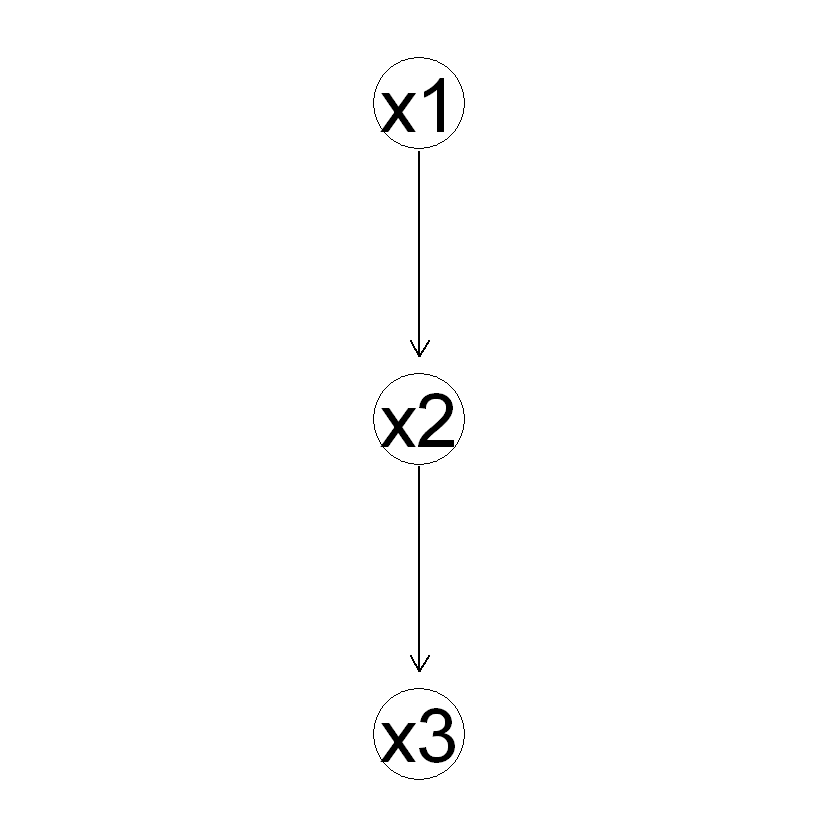

In [8]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)
end.time <- Sys.time()
cat("Time of computation:",end.time - start.time,"sec")

plot(net)

# K2 for binary generated data

* Simplest case. x2 and x3 depends on x1. We collect the time of computation in function of the length of the dataset, we will this for the algorithm with and without logarithm.

In [9]:
#WITHOUT LOGARITHM:
time_n_l<-NULL
N_n_l<-seq(3,190,1)
for (i in N_n_l){
    n <- i
    x1 <- rbinom(n, 1, 1/2)
    x2 <- rep(0,n)
    x3 <- rep(0,n)

    idx <- which(x1 == 1)

    rand <- runif(length(idx))
    x2[idx[rand >= 0.20]] <- 1

    rand <- runif(length(idx))
    x3[idx[rand >= 0.40]] <- 1

    D <- data.frame(x1, x2, x3)
    n <- ncol(D)
    u <- 2
    order <- names(D)
    
    start.time <- Sys.time()
    K2(n, u, order, D, l= FALSE)
    end.time <- Sys.time()
    time_n_l<-c(time_n_l,end.time - start.time)
    
    }

Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x2 x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parent

In [10]:
#WITH LOGARITHM:
time_l<-NULL
N_l<-seq(10,1000,10)
for (i in N_l){
    n <- i
    x1 <- rbinom(n, 1, 1/2)
    x2 <- rep(0,n)
    x3 <- rep(0,n)

    idx <- which(x1 == 1)

    rand <- runif(length(idx))
    x2[idx[rand >= 0.20]] <- 1

    rand <- runif(length(idx))
    x3[idx[rand >= 0.40]] <- 1

    D <- data.frame(x1, x2, x3)

    n <- ncol(D)
    u <- 2
    order <- names(D)
    start.time <- Sys.time()
    K2(n, u, order, D, l= TRUE)
    end.time <- Sys.time()
    time_l<-c(time_l,end.time - start.time)
    }

Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x1 
Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents: 

* We perform a linear fit and we build two different lines for the two structure of the K2 algorithm. We plot the results below.


Call:
lm(formula = time_n_l ~ N_n_l)

Coefficients:
(Intercept)        N_n_l  
  5.866e-03    3.716e-05  



Call:
lm(formula = time_l ~ N_l)

Coefficients:
(Intercept)          N_l  
  4.679e-03    4.592e-05  


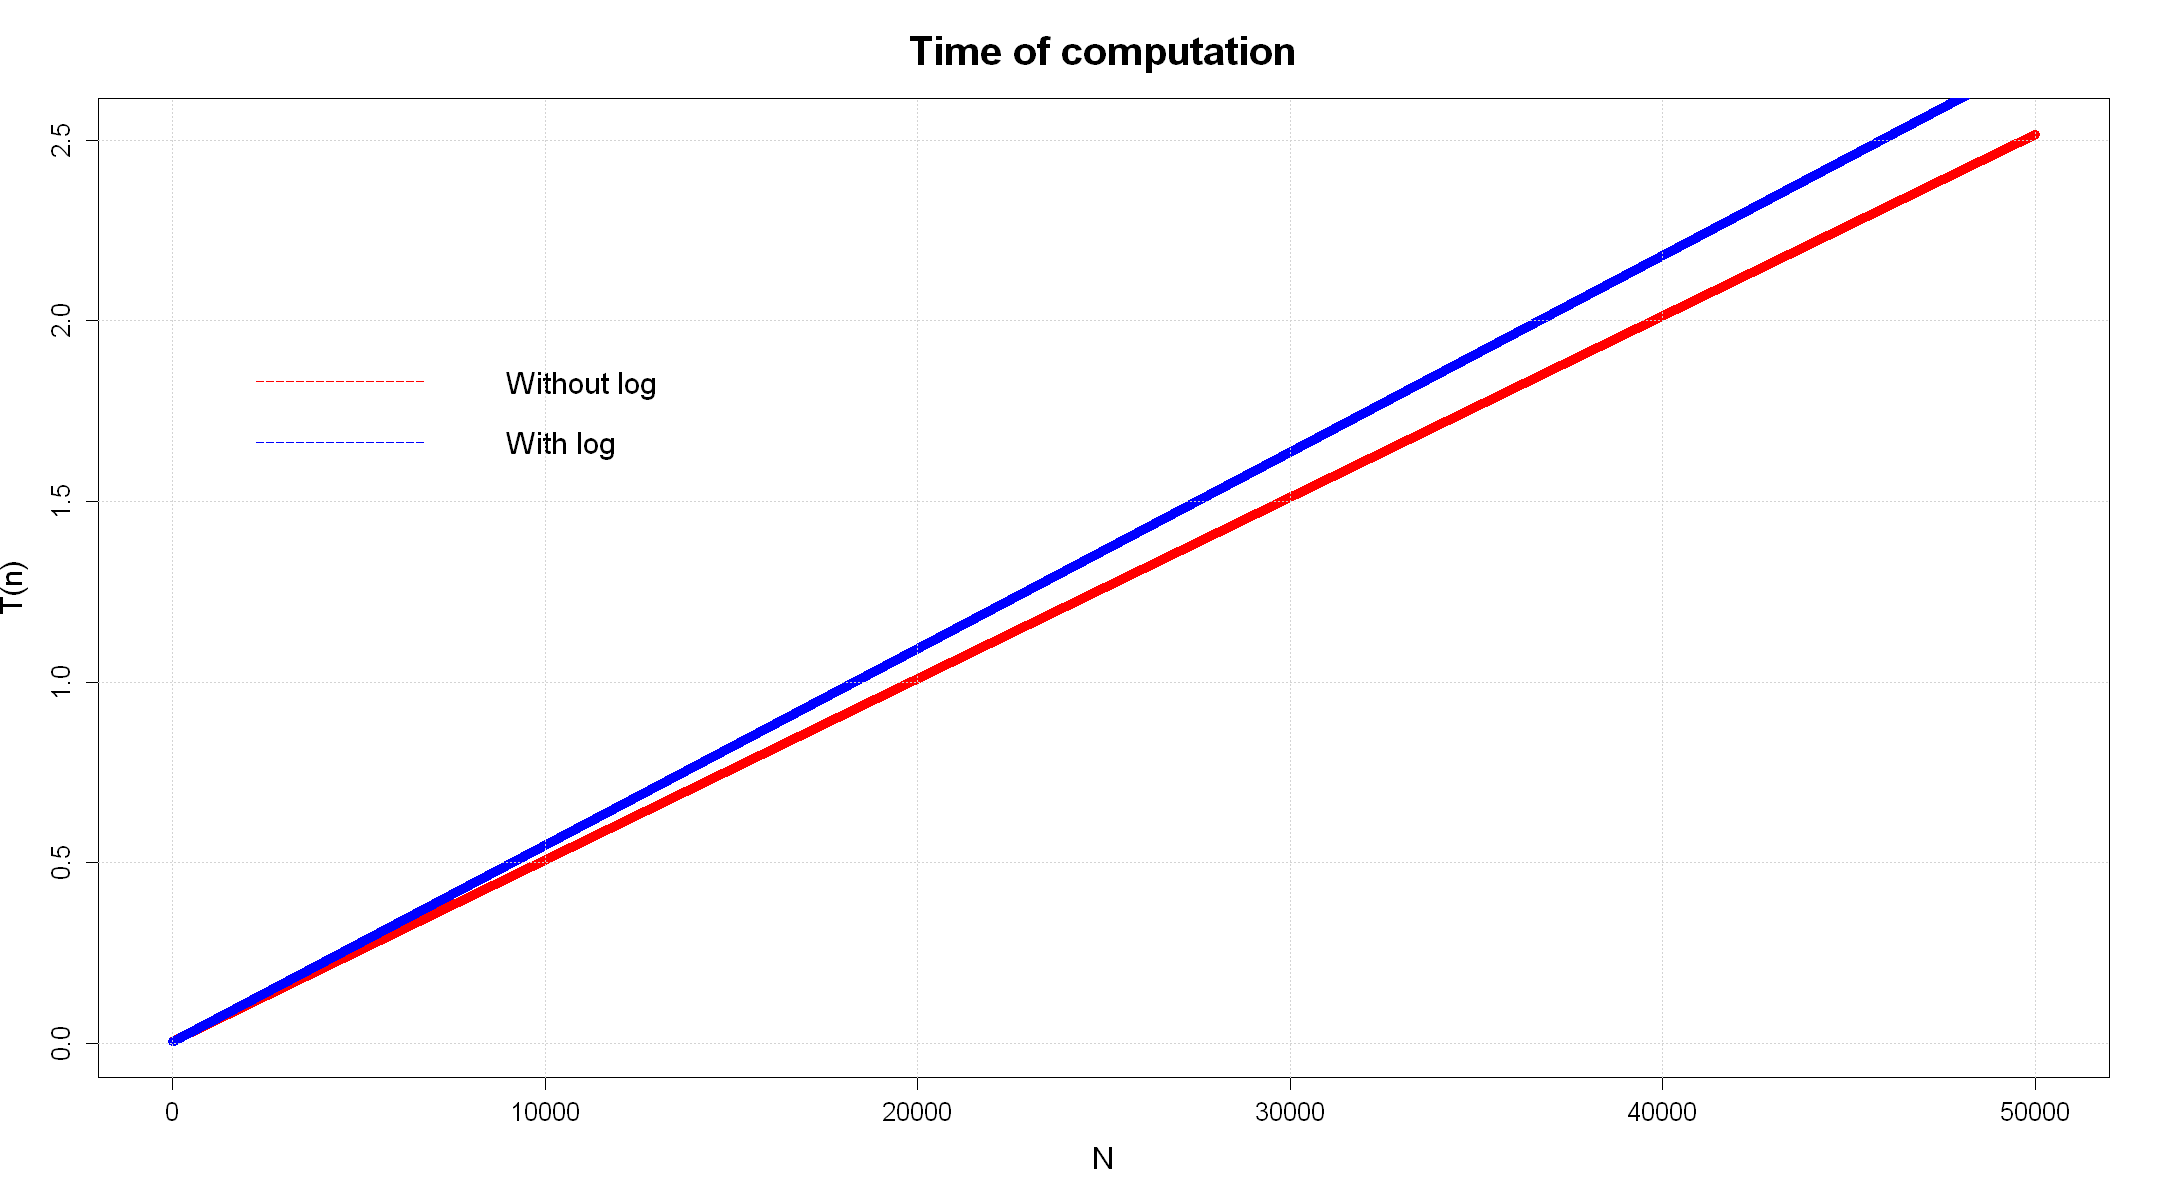

In [11]:
x<-seq(0,50000,1)
model_n_l=lm(time_n_l~N_n_l)
model_n_l
model_l=lm(time_l~N_l)
model_l

q_n_l<-5.569e-03
q_l<- 0.0043390

m_n_l<-5.019e-05
m_l<-0.0000544   

y_n_l<-m_n_l*x+q_n_l
y_l<-m_l*x+q_l


options(repr.plot.width=18, repr.plot.height=10)
plot(x, y_n_l, type = "b", 
     col = "red",main = "Time of computation", xlab = "N", ylab = "T(n)",
    cex.main=2,cex.axis=1.3,cex.lab=1.5)

lines(x, y_l,  col = "blue", type = "b", lty = 2)

legend(0,2, inset=0.05,legend=c("Without log","With log"), col=c("red","blue"),
       lty=5:5, cex=1.5,box.lty=0,bty = "n")

grid()

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



Time of computation: 0.01600003 sec

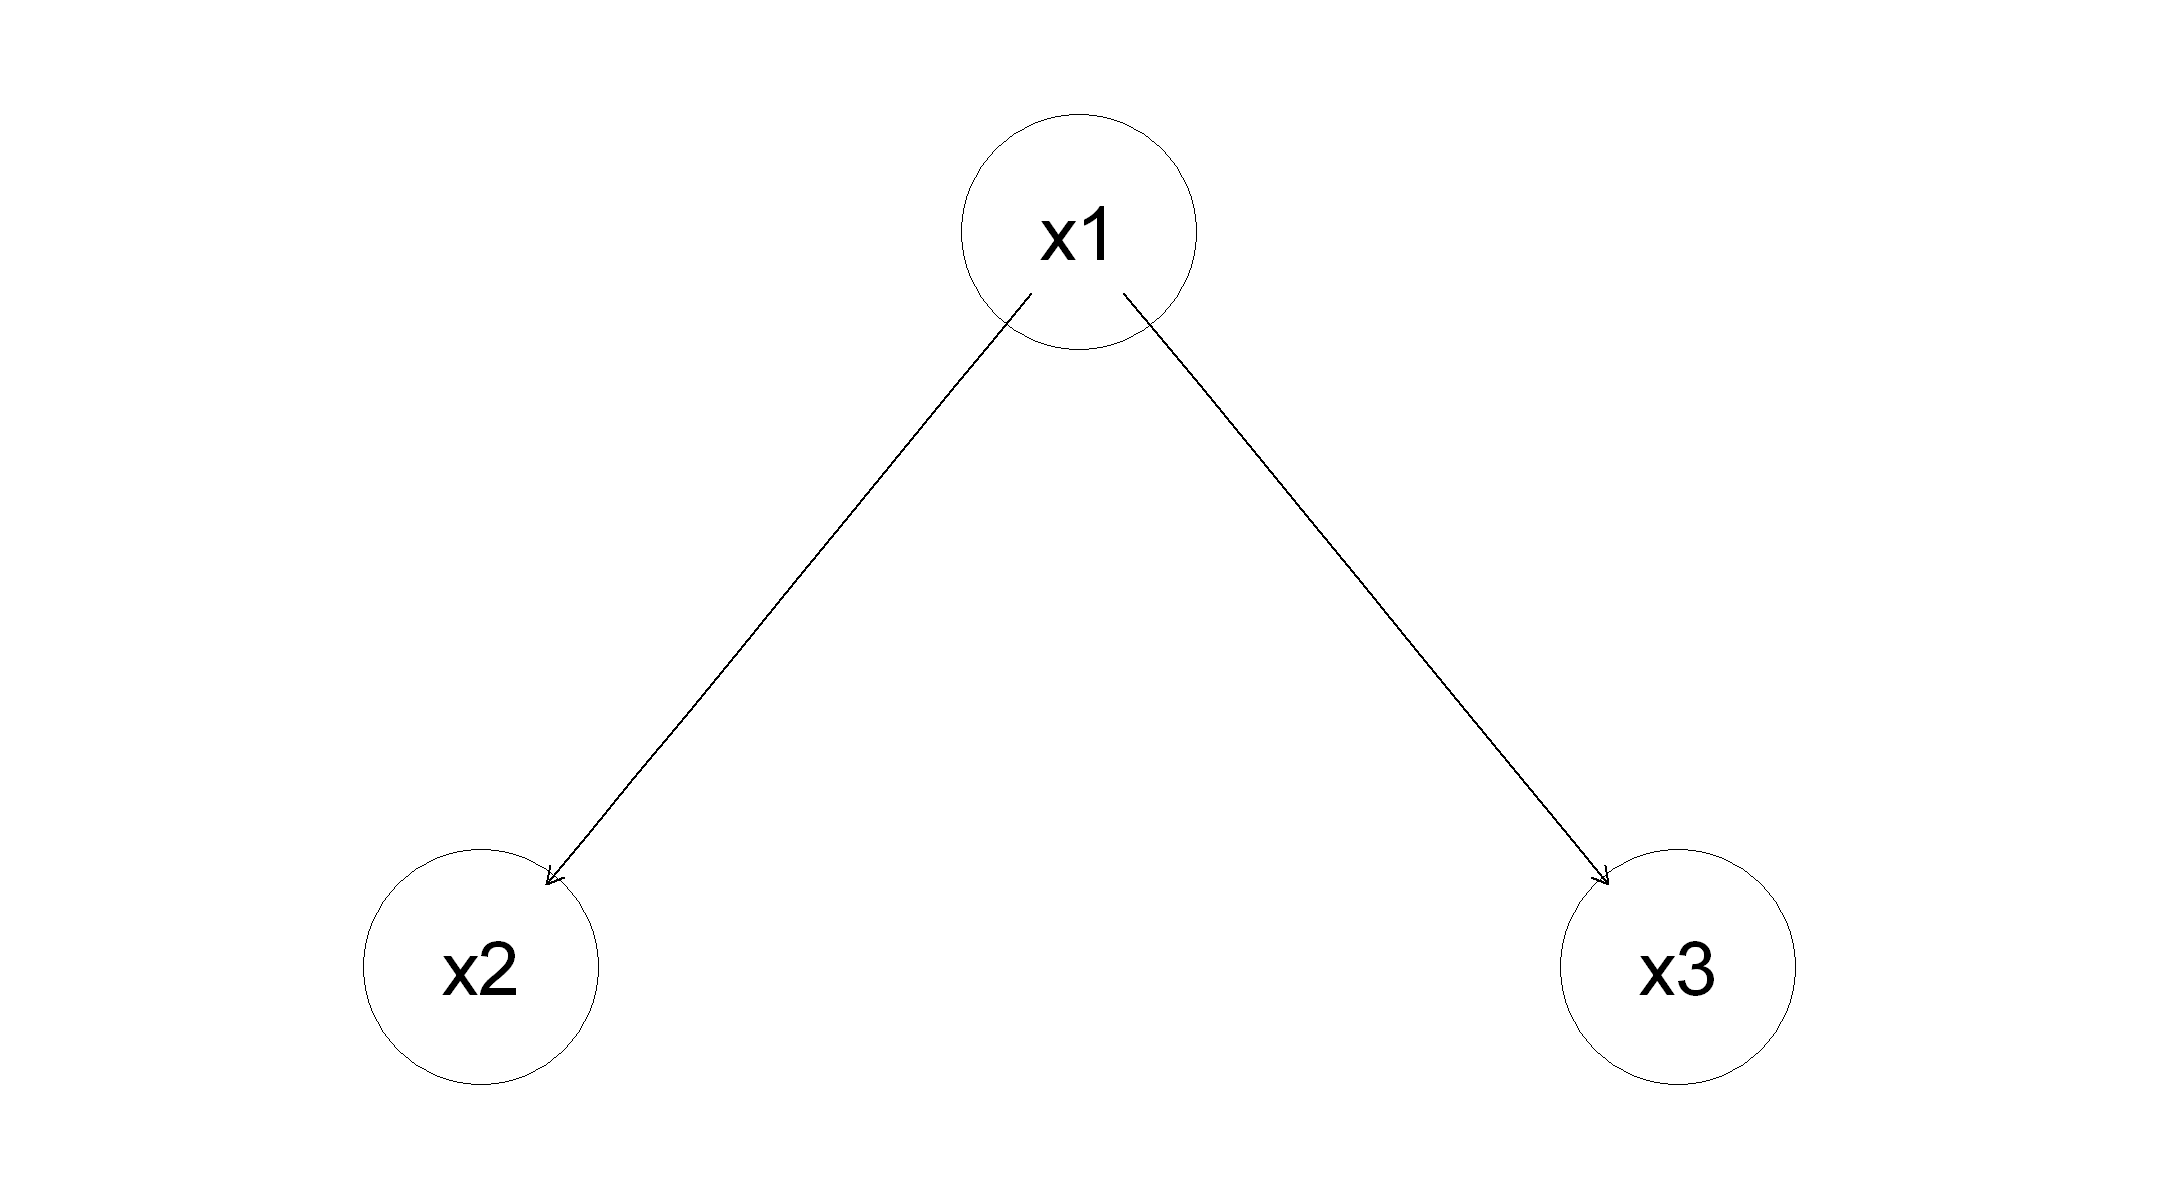

In [12]:
dataset <- BNDataset(data = D,
                    discreteness = rep('d',3),
                    variables = c("x1", "x2", "x3"),
                    starts.from = 0,
                    node.sizes = c(2,2,2))

layers <- c(1,2,3)
u <- 2

start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)
end.time <- Sys.time()
cat("Time of computation:",end.time - start.time,"sec")

plot(net)

* x2 depends on x1 and x3 depends on x2

In [13]:
n <- 100
size <- 2
prob <- 1/3

x1 <- rbinom(n, size, prob)

idx <- which(x1 == 1)
x2 <- rep(0,n)
rand <- runif(length(idx))
x2[idx[rand >= 0.70]] <- 2

idx2 <- which(x2 == 2)
x3 <- rep(0,n)
rand <- runif(length(idx2))
x3[idx2[rand <= 0.20]] <- 1

D <- data.frame(x1, x2, x3)

n <- ncol(D)
u <- 2
order <- names(D)

In [14]:
head(D)

,x1,x2,x3
,<int>,<dbl>,<dbl>
1,2,0,0
2,0,0,0
3,0,0,0
4,1,0,0
5,2,0,0
6,0,0,0


In [15]:
start.time <- Sys.time()
K2(n, u, order, D, l= FALSE)
end.time <- Sys.time()
cat("Without log:",end.time - start.time,"sec \n")
cat("\n")
start.time <- Sys.time()
K2(n, u, order, D, l= TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x2 
Without log: 0.02000213 sec 

Node:  x1  Parents:  
Node:  x2  Parents:  x1 
Node:  x3  Parents:  x2 
With log: 0.01600599 sec 


bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



Time of computation: 0.01602912 sec

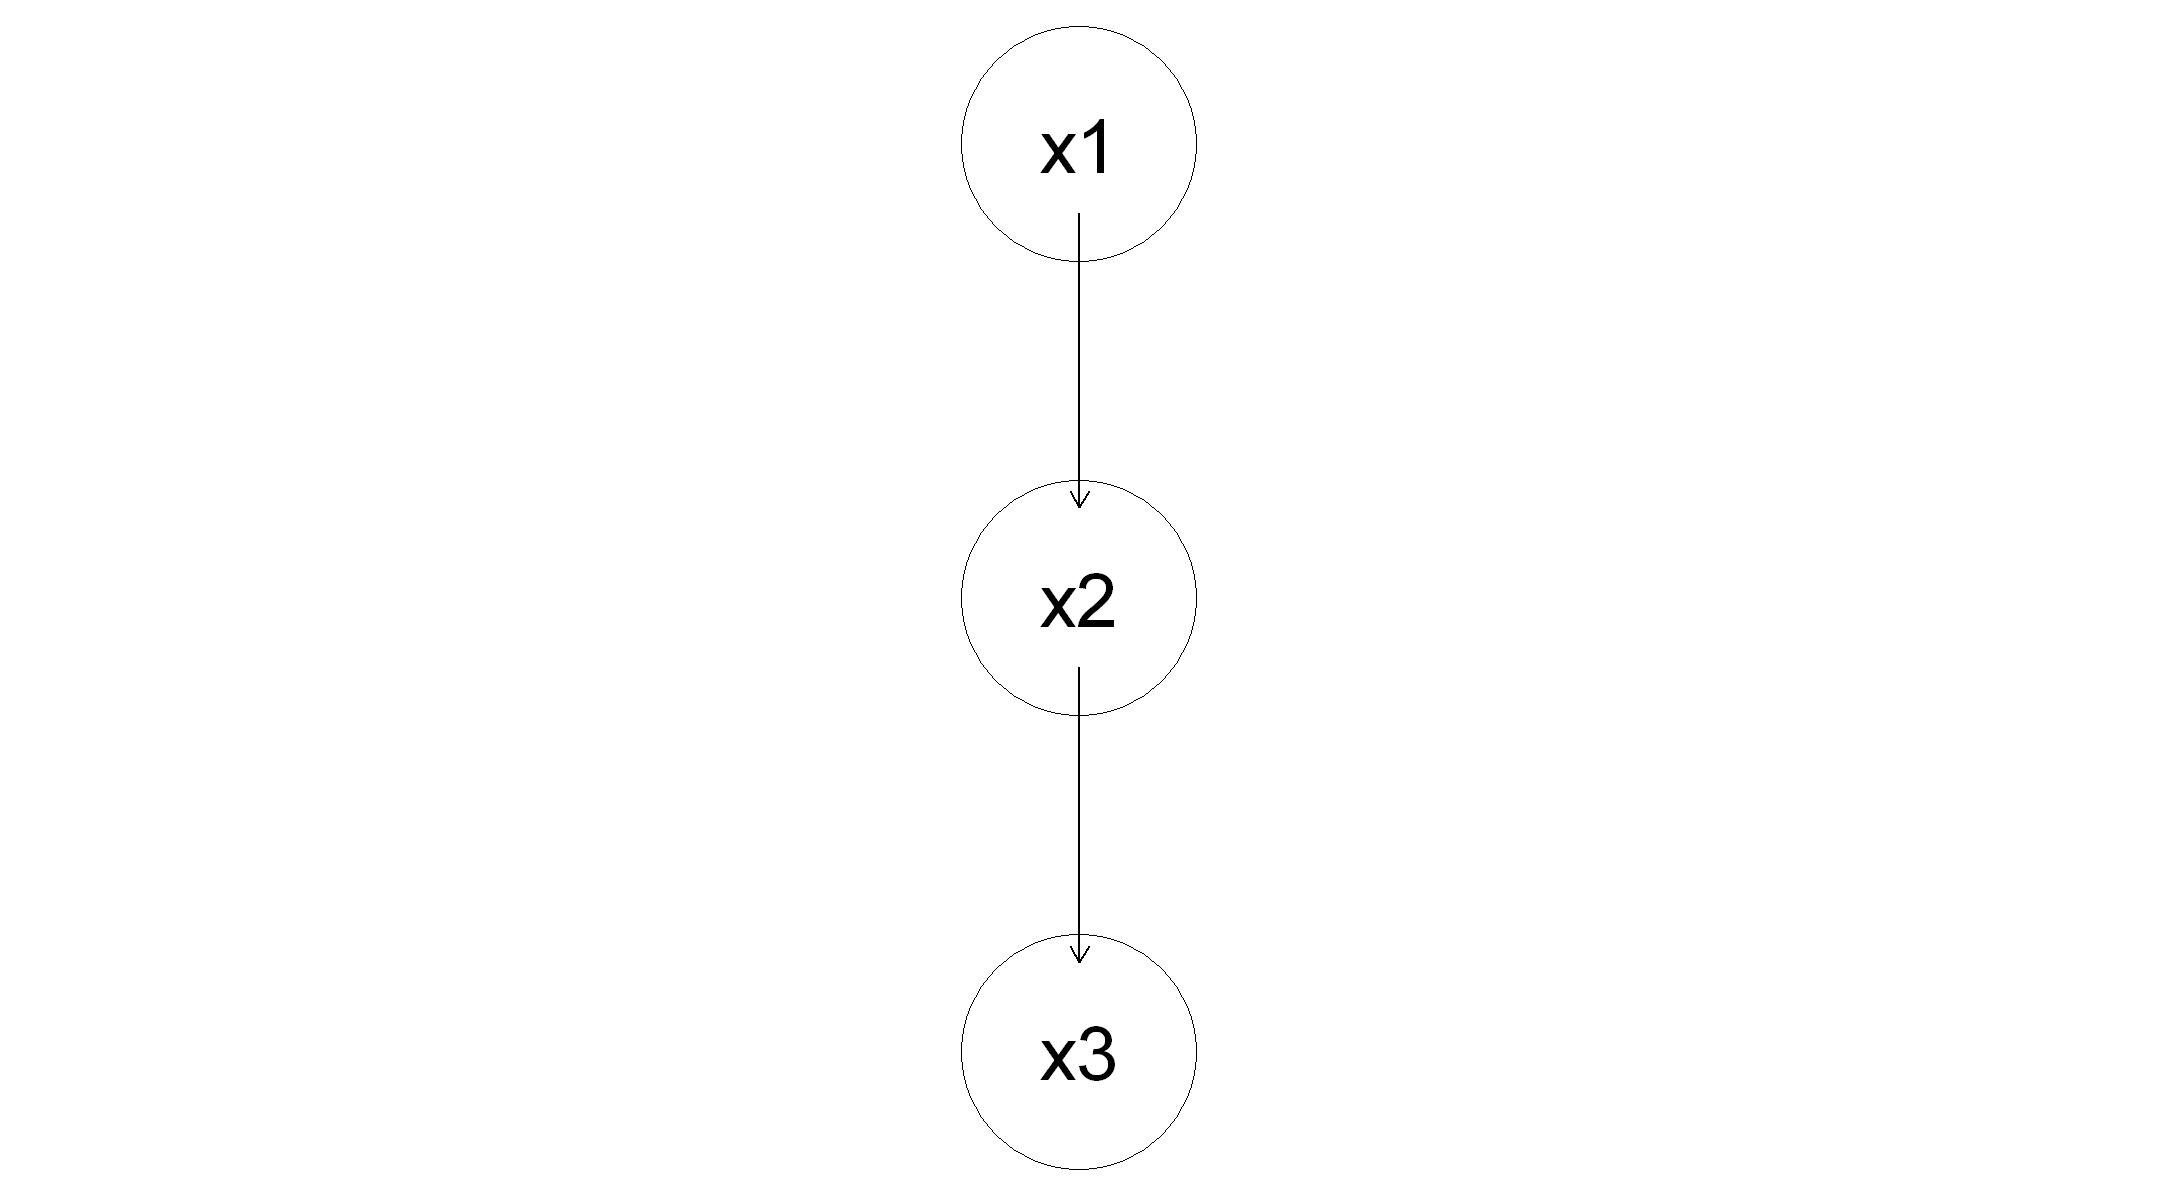

In [16]:
dataset <- BNDataset(data = D,
                    discreteness = rep('d',3),
                    variables = c("x1", "x2", "x3"),
                    starts.from = 0,
                    node.sizes = c(3,3,2))

layers <- c(1,2,3)
u <- 2

start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)
end.time <- Sys.time()
cat("Time of computation:",end.time - start.time,"sec")

plot(net)

* Multiple nodes and values

In [17]:
n <- 50

x1 <- rbinom(n, 1, prob = 1/5)
x2 <- sample(0:3, n, replace = T)
x3 <- rep(0,n)
x4 <- rep(0,n)

idx2 <- which(x1 == 1)
rand <- runif(length(idx2))
x3[idx2[rand >= 0.20]] <- 1

idx2 <- which(x2 == 3)
rand <- runif(length(idx2))
x3[idx2[rand >= 0.10]] <- 2

idx3 <- which(x3 == 1)
rand <- runif(length(idx3))
x4[idx3[rand >= 0.30]] <- 1

idx3 <- which(x2 == 1)
rand <- runif(length(idx3))
x4[idx3[rand >= 0.20]] <- 2

D <- data.frame(x1, x2, x3, x4)

n <- ncol(D)
u <- 2
order <- names(D)

In [18]:
head(D, 10)

,x1,x2,x3,x4
,<int>,<int>,<dbl>,<dbl>
1,1,2,1,1
2,0,1,0,2
3,0,0,0,0
4,0,3,2,0
5,1,3,2,0
6,0,0,0,0
7,1,2,1,1
8,1,3,2,0
9,0,1,0,2


* Speed of computation using the implemented algorithm

In [19]:
start.time <- Sys.time()
K2(n, u, order, D, l= FALSE)
end.time <- Sys.time()
cat("Without log:",end.time - start.time,"sec \n")
cat("\n")
start.time <- Sys.time()
K2(n, u, order, D, l= TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  x1  Parents:  
Node:  x2  Parents:  
Node:  x3  Parents:  x2 x1 
Node:  x4  Parents:  x2 x3 
Without log: 0.03600311 sec 

Node:  x1  Parents:  
Node:  x2  Parents:  
Node:  x3  Parents:  x2 x1 
Node:  x4  Parents:  x2 
With log: 0.03997493 sec 


bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



Time of computation: 0.01599789 sec

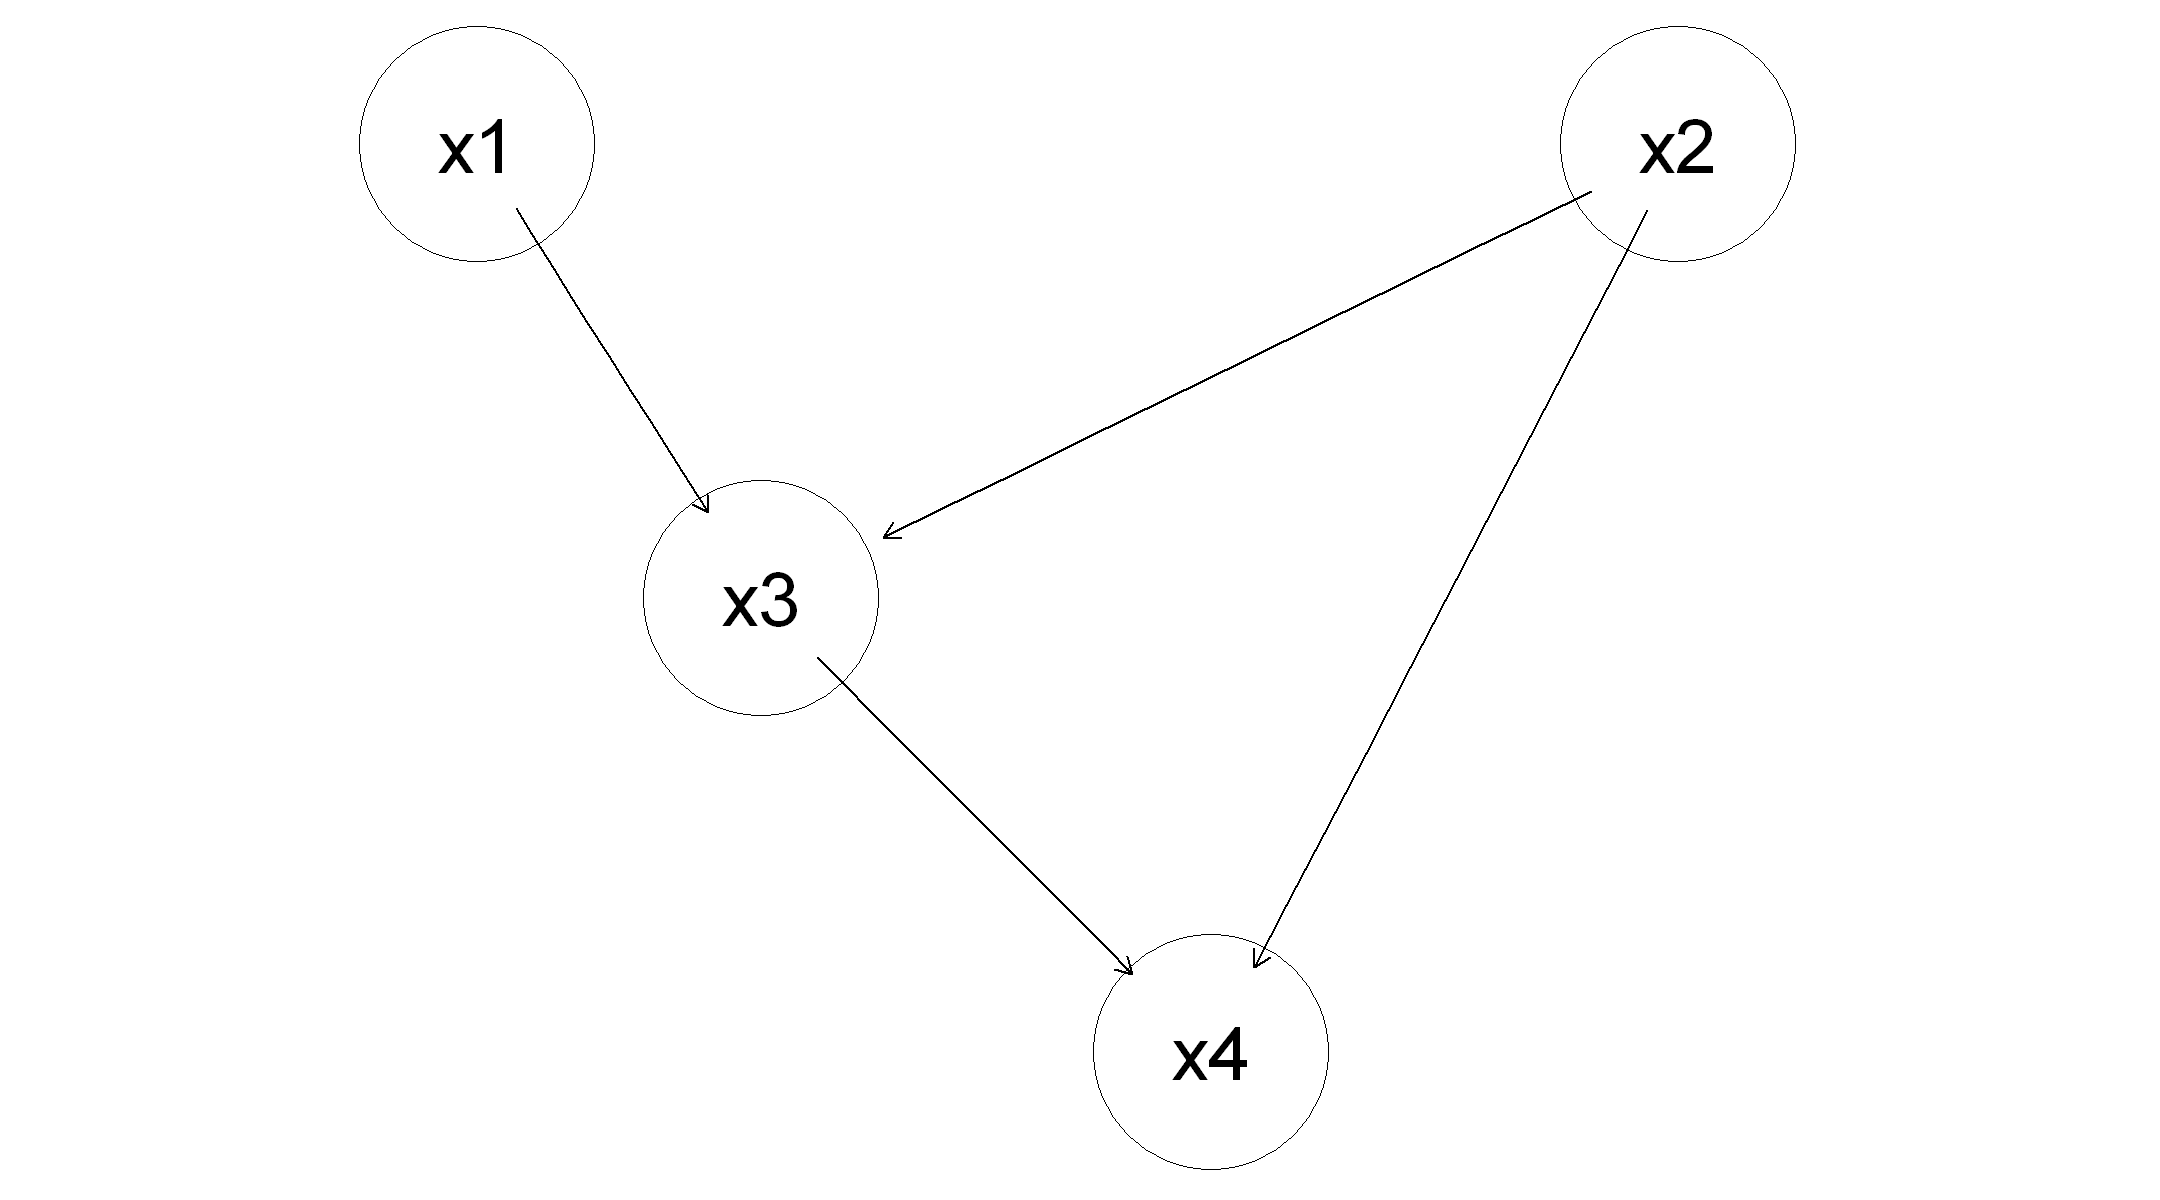

In [20]:
dataset <- BNDataset(data = D,
                    discreteness = rep('d',4),
                    variables = c("x1", "x2", "x3", 'x4'),
                    starts.from = 0,
                    node.sizes = c(2,4,3,3))

layers <- c(1,2,3,4)
u <- 2

start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, layering = layers, max.parents = u)
end.time <- Sys.time()
cat("Time of computation:",end.time - start.time,"sec")

plot(net)

# Asia dataset

In [21]:
data <- data.frame(raw.data(asia()))

n <- ncol(data)
u <- 2
order <- c('Asia','Smoke','Tubercolosys',
           'LungCancer','Either','Bronchitis','X-ray','Dyspnea')

names(data) <- c('Asia', 'Tubercolosys', 'Smoke', 'LungCancer' ,'Bronchitis', 'Either' ,'X-ray', 'Dyspnea')

In [22]:
head(data,10)

,Asia,Tubercolosys,Smoke,LungCancer,Bronchitis,Either,X-ray,Dyspnea
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,2,1,1,1,2,1,2
2,2,1,1,1,1,1,2,1
3,1,1,2,1,1,1,2,1
4,2,1,2,1,1,1,2,1
5,2,1,2,1,1,1,1,2
6,2,1,2,1,1,1,2,2
7,2,1,2,1,1,1,2,2
8,2,1,2,1,1,1,1,2
9,2,1,2,1,1,1,1,2


In [23]:
start.time <- Sys.time()
K2(n, u, order, data, l= TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  Asia  Parents:  
Node:  Smoke  Parents:  Asia 
Node:  Tubercolosys  Parents:  Asia 
Node:  LungCancer  Parents:  
Node:  Either  Parents:  Tubercolosys 
Node:  Bronchitis  Parents:  Either Tubercolosys 
Node:  X-ray  Parents:  Either 
Node:  Dyspnea  Parents:  Smoke Either 
With log: 5.14087 sec 


In [24]:
dataset <- BNDataset(data = data,
                    discreteness = rep('d',8),
                    variables = c('Asia', 'Tubercolosys', 'Smoke', 'LungCancer' ,'Bronchitis', 'Either' ,'X-ray', 'Dyspnea'),
                    starts.from = 1,
                    node.sizes = c(2,2,2,2,2,2,2,2))

layers <- c(1, 3, 2, 4, 6, 5, 7, 8)
u <- 2

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



 0.03200006 sec 


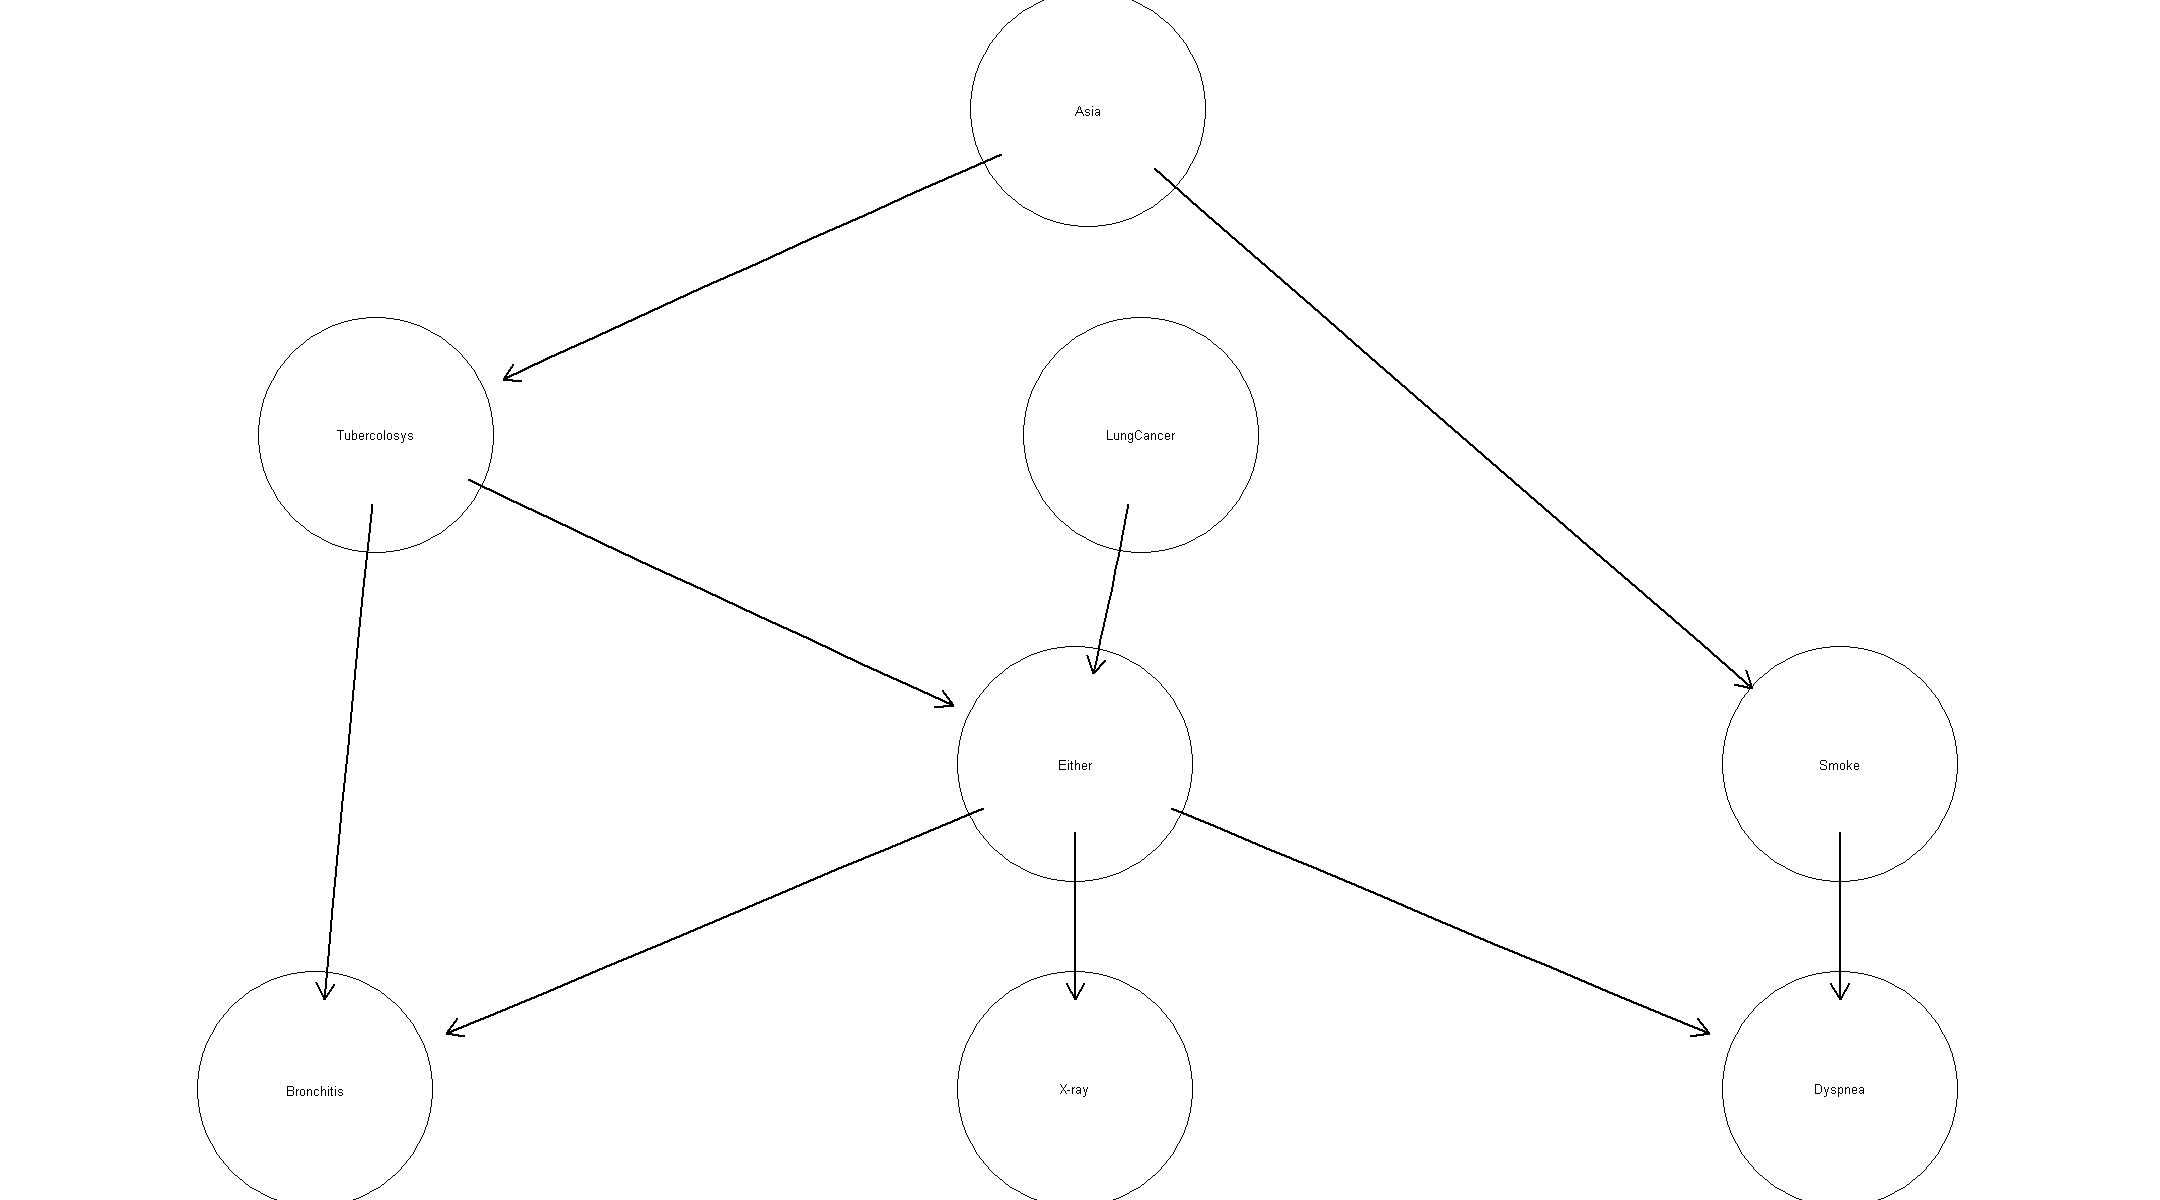

In [25]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, max.parents = u, layering = layers)
end.time <- Sys.time()
cat("",end.time - start.time,"sec \n")
plot(net)

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



 0.08398986 sec 


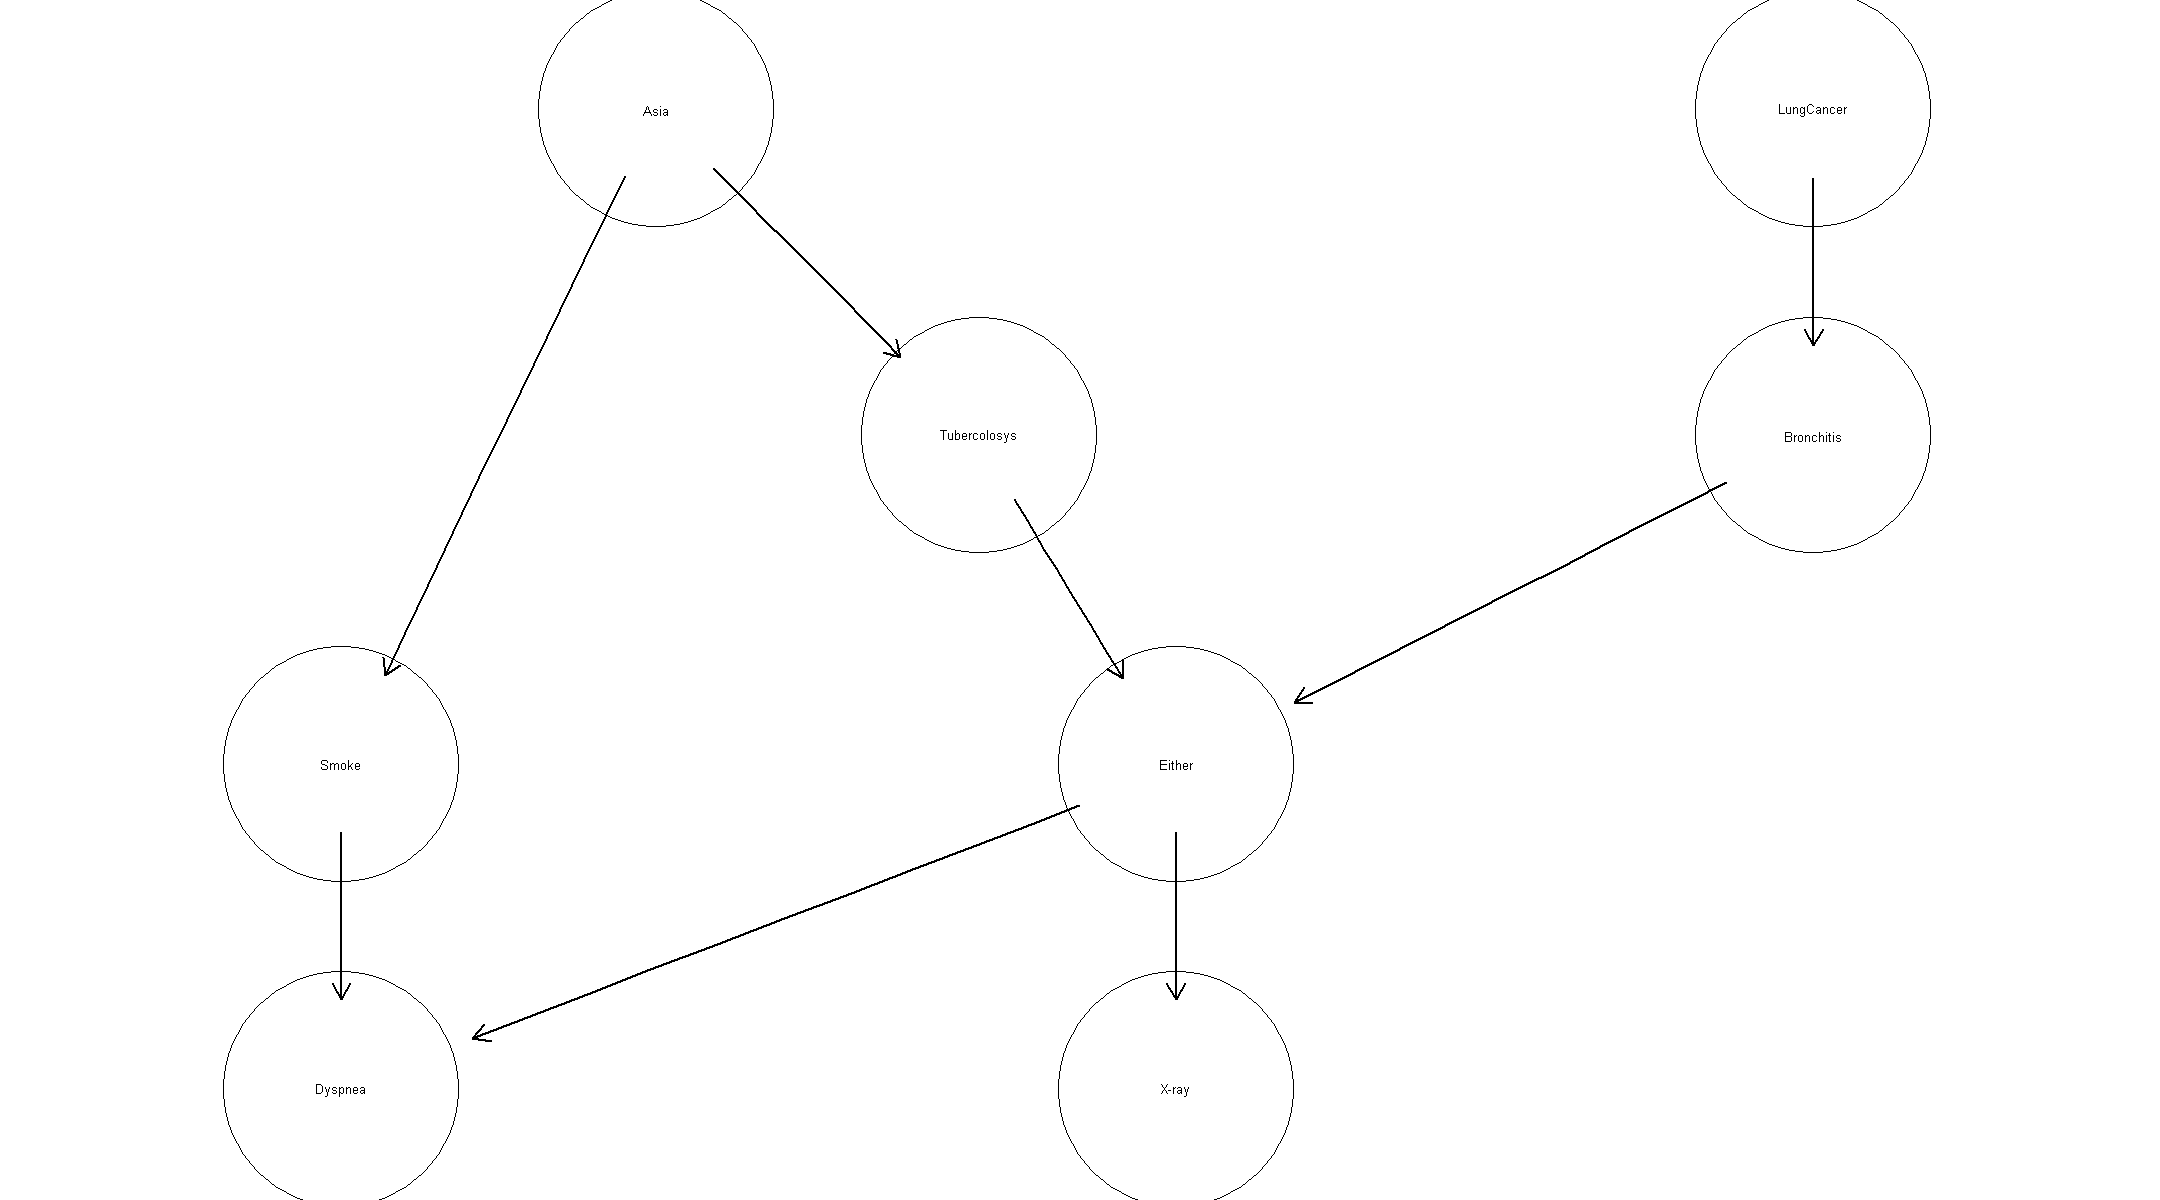

In [26]:
start.time <- Sys.time()
net2 <- learn.network(algo = "sm", x = dataset)
end.time <- Sys.time()
cat("",end.time - start.time,"sec \n")
plot(net2)

# Learning test

* Preprocessing the data

In [27]:
head(learning.test,10)

,A,B,C,D,E,F
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,b,c,b,a,b,b
2,b,a,c,a,b,b
3,a,a,a,a,a,a
4,a,a,a,a,b,b
5,a,a,b,c,a,a
6,c,c,a,c,c,a
7,c,c,b,c,c,a
8,b,b,a,b,b,b
9,b,b,b,a,c,a


In [28]:
converter<-function(A){
    n<-length(A)
    for (i in 1:n){
        if (A[i] == "a"){
            A[i]<-as.numeric(1)
            
        }
        else if( A[i]=="b"){
             A[i]<-as.numeric(2)
        }
        else{
            A[i]<-as.numeric(3)
        }
    }
    return(as.numeric(A))
}
learning.test <- data.frame(lapply(learning.test, as.character), stringsAsFactors=FALSE)
data <- data.frame(apply(learning.test, MARGIN=2, converter ))

head(data,10)

,A,B,C,D,E,F
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,3,2,1,2,2
2,2,1,3,1,2,2
3,1,1,1,1,1,1
4,1,1,1,1,2,2
5,1,1,2,3,1,1
6,3,3,1,3,3,1
7,3,3,2,3,3,1
8,2,2,1,2,2,2
9,2,2,2,1,3,1


* Speed of computation using the implemented algorithm

In [29]:
n <- ncol(data)
u <- 2
order <- c('F', 'C','A','B','E','D')

start.time <- Sys.time()
K2(n, u, order, data, l=TRUE)
end.time <- Sys.time()
cat("With log:",end.time - start.time,"sec \n")

Node:  F  Parents:  
Node:  C  Parents:  
Node:  A  Parents:  
Node:  B  Parents:  A 
Node:  E  Parents:  B F 
Node:  D  Parents:  A C 
With log: 3.188742 sec 


In [30]:
dataset <- BNDataset(data = data,
                    discreteness = rep('d',6),
                    variables = c('A', 'B','C','D','E','F'),
                    starts.from = 1,
                    node.sizes = c(3,3,3,3,3,2))

layers <- c(3, 4, 2, 6, 5, 1)
u <- 2 

bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



 0.02004004 sec 


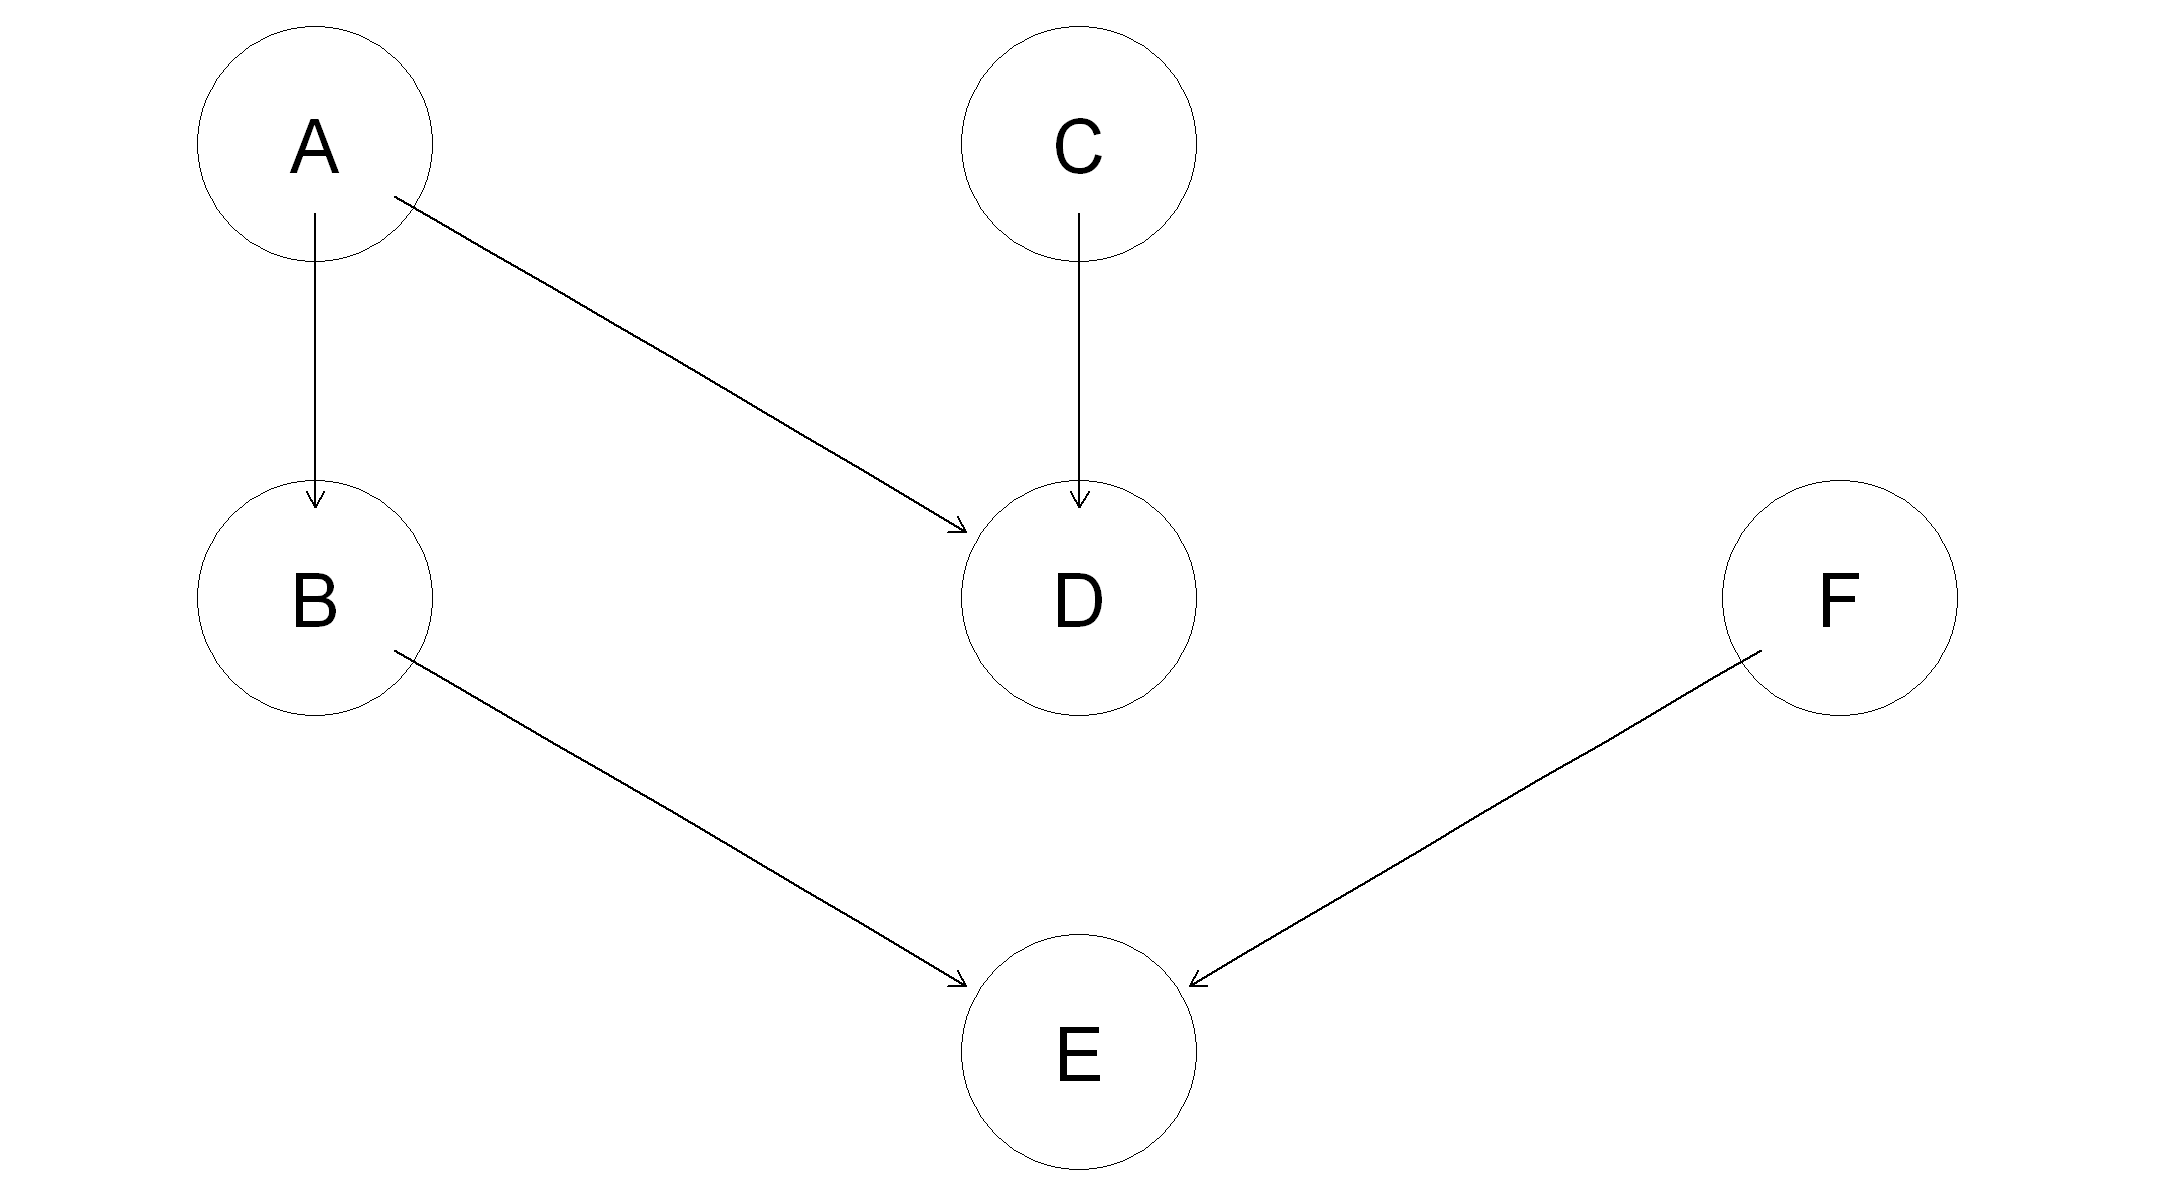

In [31]:
start.time <- Sys.time()
net <- learn.network(algo = "sm", x = dataset, max.parents = u, layering = layers)
end.time <- Sys.time()
cat("",end.time - start.time,"sec \n")
plot(net)


bnstruct :: learning the structure using SM ...

bnstruct :: learning using SM completed.

bnstruct :: learning network parameters ... 

bnstruct :: parameter learning done.



 0.02399683 sec 


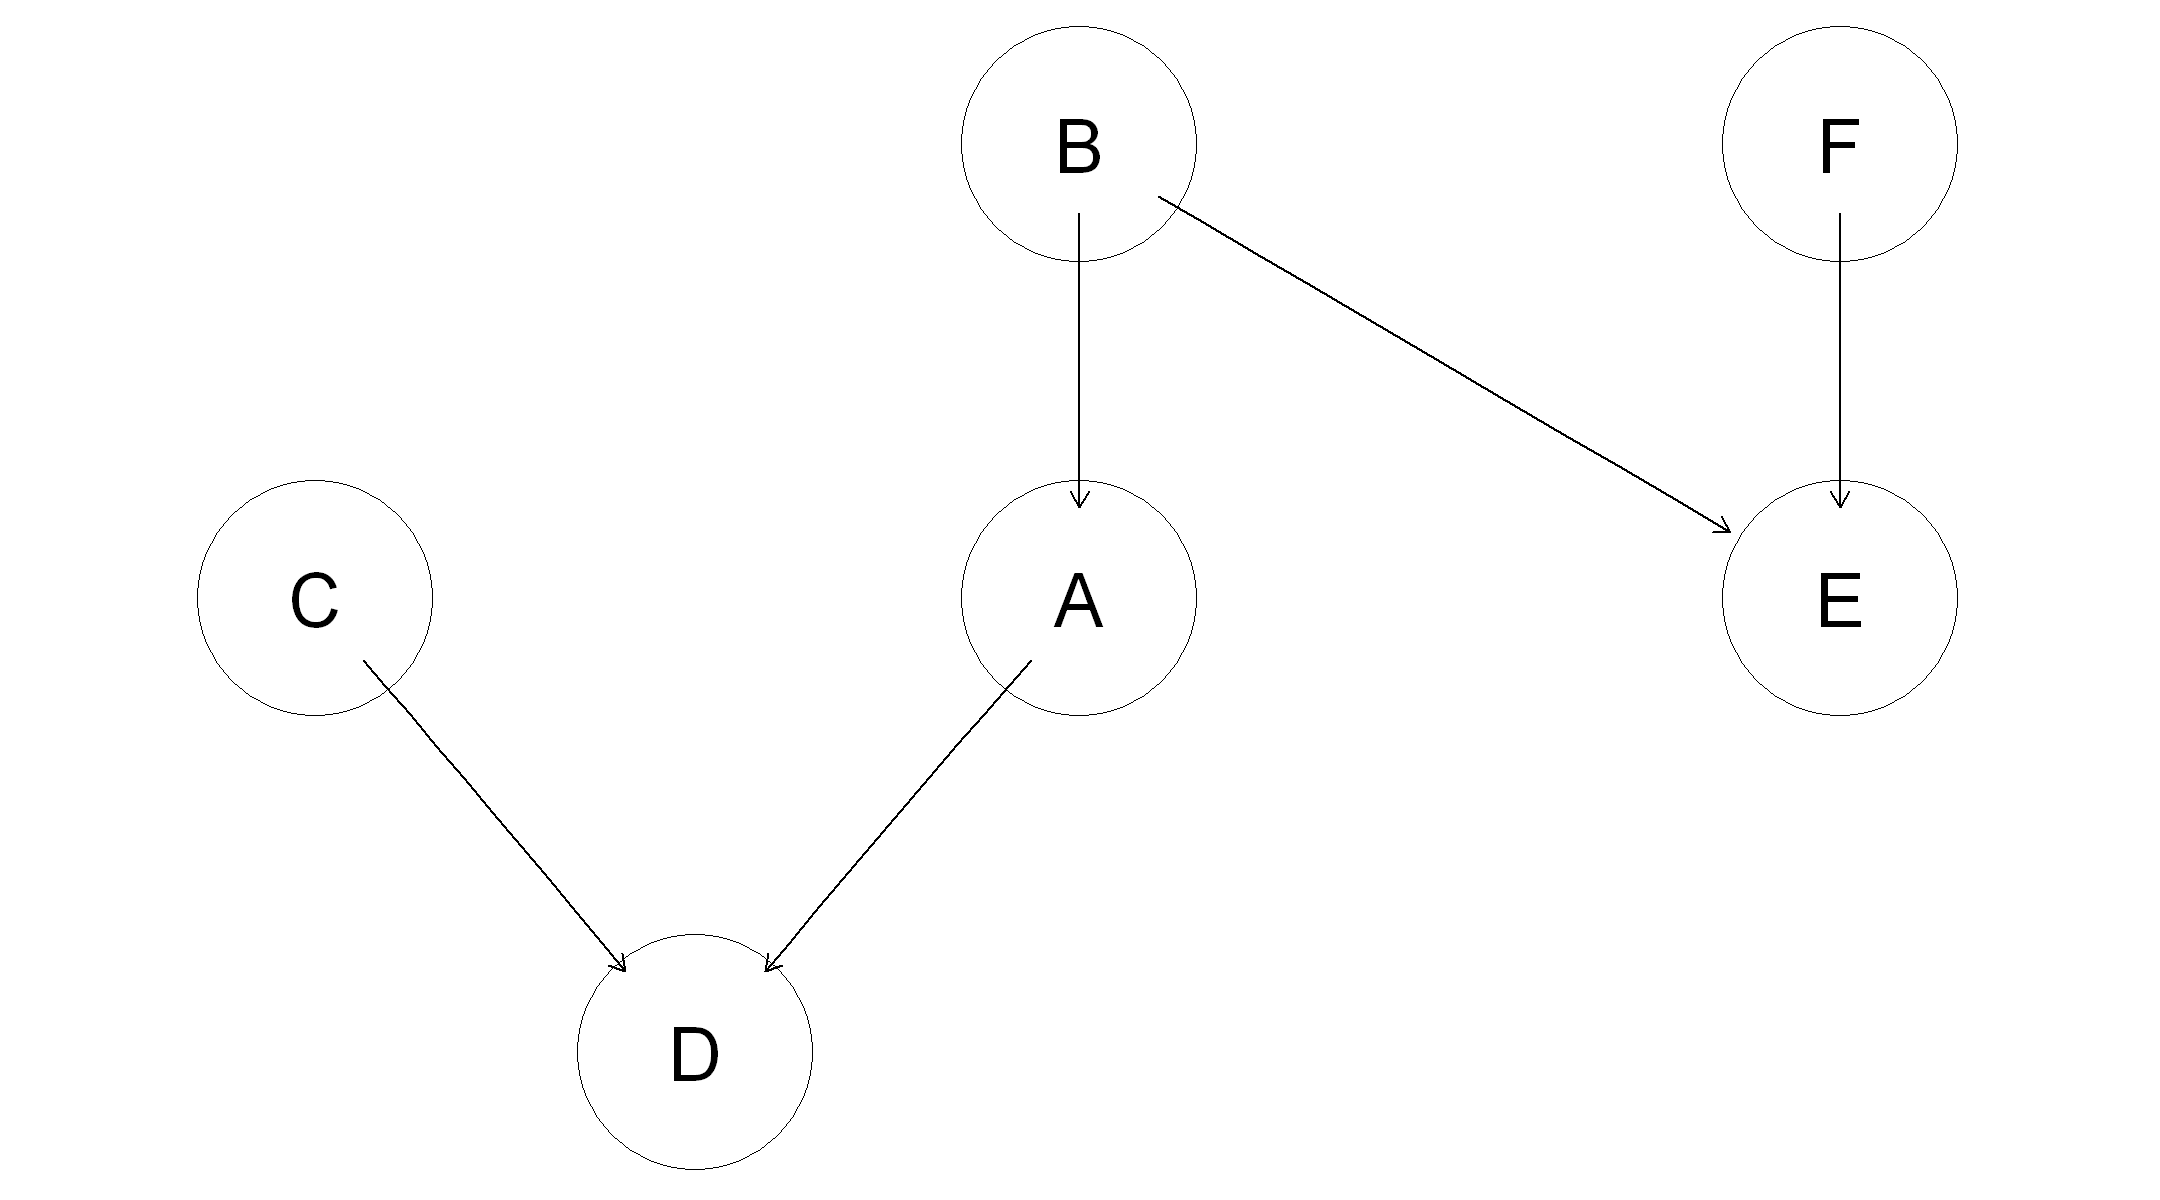

In [32]:
start.time <- Sys.time()
net2 <- learn.network(algo = "sm", x = dataset)
end.time <- Sys.time()
cat("",end.time - start.time,"sec \n")
plot(net2)

# Datasets for checking the O( $n^4$) trend

In [33]:
counter_n_l<-NULL
counter_l<-NULL

# D n=3 m=10
x <- sample(0:1, 30, replace = TRUE)
D3 <- matrix(x, 10, 3)
D3 <- data.frame(D3)
n <- ncol(D3)
order <- names(D3)
u<-n
start.time <- Sys.time()
K2(n, u, order, D3, l=FALSE)
end.time <- Sys.time()
counter_n_l<-c(counter_n_l,end.time-start.time)
start.time <- Sys.time()
K2(n, u, order, D3, l=TRUE)
end.time <- Sys.time()
counter_l<-c(counter_l,end.time-start.time)

# D n=5 m=10
x <- sample(0:1, 50, replace = TRUE)
D5 <- matrix(x, 10, 5)
D5 <- data.frame(D5)
n <- ncol(D5)
order <- names(D5)
u<-n
start.time <- Sys.time()
K2(n, u, order, D5, l=FALSE)
end.time <- Sys.time()
counter_n_l<-c(counter_n_l,end.time-start.time)
start.time <- Sys.time()
K2(n, u, order, D5, l=TRUE)
end.time <- Sys.time()
counter_l<-c(counter_l,end.time-start.time)

# D n=7 m=10
x <- sample(0:1, 70, replace = TRUE)
D7 <- matrix(x, 10, 7)
D7 <- data.frame(D7)
n <- ncol(D7)
order <- names(D7)
u<-n
start.time <- Sys.time()
K2(n, u, order, D7, l=FALSE)
end.time <- Sys.time()
counter_n_l<-c(counter_n_l,end.time-start.time)
start.time <- Sys.time()
K2(n, u, order, D7, l=TRUE)
end.time <- Sys.time()
counter_l<-c(counter_l,end.time-start.time)

# D n=10 m=10
x <- sample(0:1, 100, replace = TRUE)
D10 <- matrix(x, 10, 10)
D10 <- data.frame(D10)
n <- ncol(D10)
order <- names(D10)
u<-n-1
start.time <- Sys.time()
K2(n, u, order, D10, l=FALSE)
end.time <- Sys.time()
counter_n_l<-c(counter_n_l,end.time-start.time)
start.time <- Sys.time()
K2(n, u, order, D10, l=TRUE)
end.time <- Sys.time()
counter_l<-c(counter_l,end.time-start.time)

# D n=12 m=10
x <- sample(0:1, 120, replace = TRUE)
D12 <- matrix(x, 10, 12)
D12 <- data.frame(D12)
n <- ncol(D12)
order <- names(D12)
u<-n
start.time <- Sys.time()
K2(n, u, order, D12, l=FALSE)
end.time <- Sys.time()
counter_n_l<-c(counter_n_l,end.time-start.time)
start.time <- Sys.time()
K2(n, u, order, D12, l=TRUE)
end.time <- Sys.time()
counter_l<-c(counter_l,end.time-start.time)

# D n=15 m=10
x <- sample(0:1, 150, replace = TRUE)
D15 <- matrix(x, 10, 15)
D15 <- data.frame(D15)
n <- ncol(D15)
order <- names(D15)
u<-n
start.time <- Sys.time()
K2(n, u, order, D15, l=FALSE)
end.time <- Sys.time()
counter_n_l<-c(counter_n_l,end.time-start.time)
start.time <- Sys.time()
K2(n, u, order, D15, l=TRUE)
end.time <- Sys.time()
counter_l<-c(counter_l,end.time-start.time)

# D n=20 m=10
x <- sample(0:1, 200, replace = TRUE)
D20 <- matrix(x, 10, 20)
D20 <- data.frame(D20)
n <- ncol(D20)
order <- names(D20)
u<-n
start.time <- Sys.time()
K2(n, u, order, D20, l=FALSE)
end.time <- Sys.time()
counter_n_l<-c(counter_n_l,end.time-start.time)
start.time <- Sys.time()
K2(n, u, order, D20, l=TRUE)
end.time <- Sys.time()
counter_l<-c(counter_l,end.time-start.time)

Node:  X1  Parents:  
Node:  X2  Parents:  
Node:  X3  Parents:  
Node:  X1  Parents:  
Node:  X2  Parents:  
Node:  X3  Parents:  
Node:  X1  Parents:  
Node:  X2  Parents:  
Node:  X3  Parents:  X2 
Node:  X4  Parents:  
Node:  X5  Parents:  X2 X1 
Node:  X1  Parents:  
Node:  X2  Parents:  
Node:  X3  Parents:  
Node:  X4  Parents:  
Node:  X5  Parents:  
Node:  X1  Parents:  
Node:  X2  Parents:  
Node:  X3  Parents:  X1 
Node:  X4  Parents:  X3 
Node:  X5  Parents:  X1 X4 
Node:  X6  Parents:  X1 X2 
Node:  X7  Parents:  X5 X3 
Node:  X1  Parents:  
Node:  X2  Parents:  
Node:  X3  Parents:  
Node:  X4  Parents:  X3 
Node:  X5  Parents:  
Node:  X6  Parents:  
Node:  X7  Parents:  
Node:  X1  Parents:  
Node:  X2  Parents:  
Node:  X3  Parents:  X1 
Node:  X4  Parents:  X1 
Node:  X5  Parents:  X4 
Node:  X6  Parents:  X3 
Node:  X7  Parents:  
Node:  X8  Parents:  X3 
Node:  X9  Parents:  X8 
Node:  X10  Parents:  X5 X3 X1 X8 
Node:  X1  Parents:  
Node:  X2  Parents:  
Node:  X3

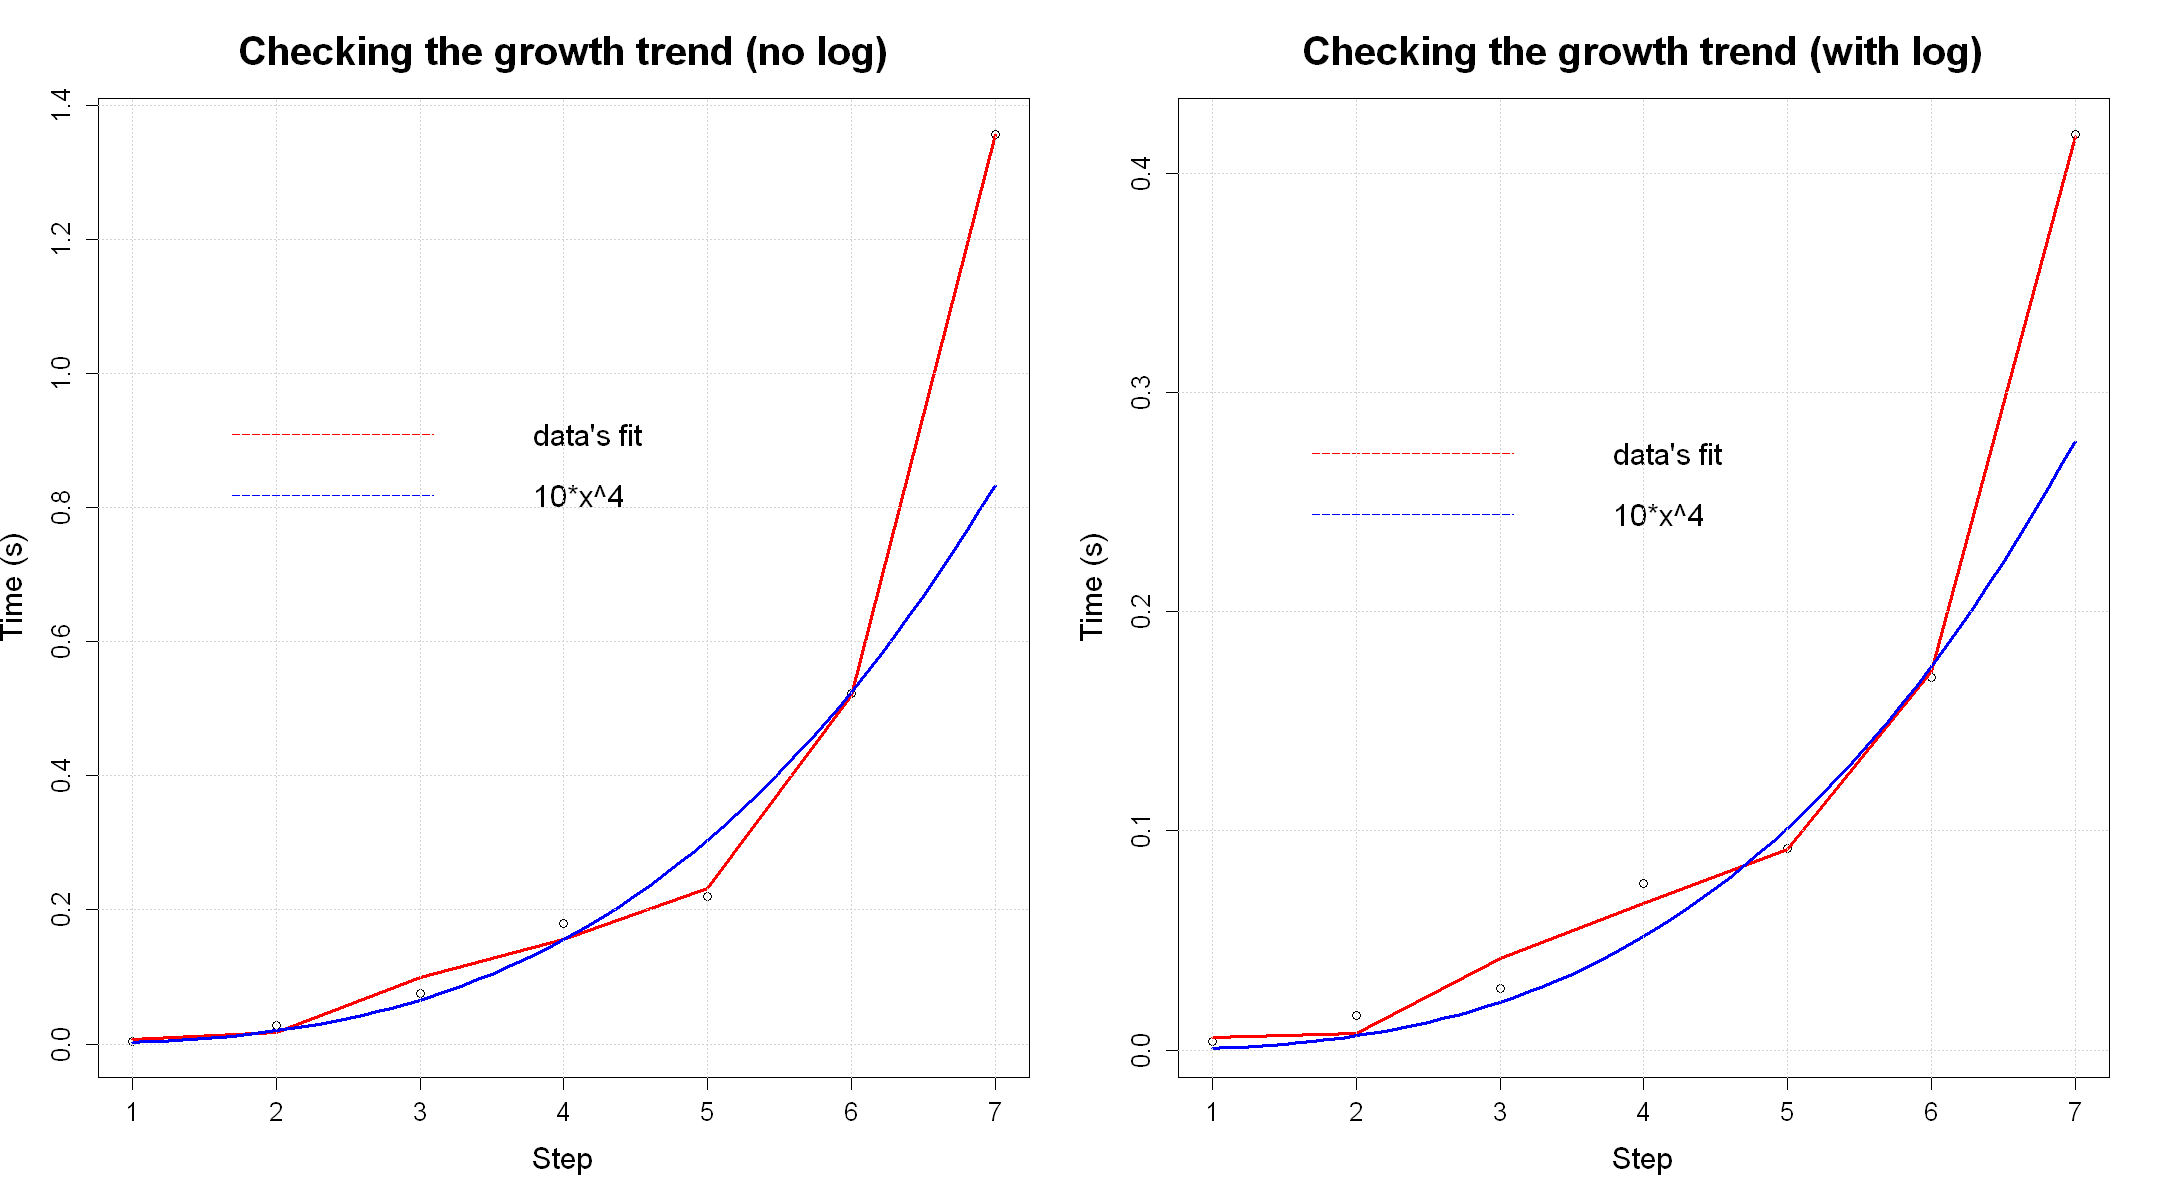

In [34]:
par(mfrow=c(1,2))
x<-seq(1,7,1)
x_dummy<-seq(1,7,0.1)
y_dummy<-x_dummy**3
y_dummy<- 15*y_dummy/sum(y_dummy)
fit_n_l <- lm(counter_n_l~poly(x,4,raw=TRUE))
fit_l <- lm(counter_l~poly(x,4,raw=TRUE))

plot(1:7,counter_n_l,xlim=c(1,7), xlab="Step", ylab="Time (s)", main="Checking the growth trend (no log)",
    cex.main=2,cex.axis=1.3,cex.lab=1.5)
lines(x, predict(fit_n_l, data.frame(x=x)),lwd=3, col="red")
lines(x_dummy,y_dummy, lwd=3 ,col="blue")
legend(1,1.0, inset=0.05,legend=c("data's fit","10*x^4"), col=c("red","blue"),
       lty=5:5, cex=1.5,box.lty=0,bty = "n")
grid()
x_dummy<-seq(1,7,0.1)
y_dummy<-x_dummy**3
y_dummy<- 5*y_dummy/sum(y_dummy)
plot(1:7,counter_l,xlim=c(1,7),  xlab="Step", ylab="Time (s)", main="Checking the growth trend (with log)",
    cex.main=2,cex.axis=1.3,cex.lab=1.5)
lines(x, predict(fit_l, data.frame(x=x)),lwd=3, col="red")
lines(x_dummy,y_dummy,lwd=3,col="blue")
legend(1,0.3, inset=0.05,legend=c("data's fit","10*x^4"), col=c("red","blue"),
       lty=5:5, cex=1.5,box.lty=0,bty = "n")
grid()